In [1]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# import tissue purifier
import tissuemosaic as tp

In [2]:
data_destination_folder = os.path.abspath('../TissueMosaic_data/testis_anndata/')

# Make a list of all the h5ad files in the data_destination_folder
fname_list = []
for f in os.listdir(data_destination_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


In [3]:
## Make plots directory if it doesn't already exist
try:
    os.mkdir("./plots")
except:
    pass

In [4]:
## set seeds
import random
import numpy as np

r_seed=t_seed=n_seed=100

random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)



In [5]:
# read in all the anndata

anndata_list = []
for fname in fname_list:
    try:
        anndata = read_h5ad(os.path.join(data_destination_folder, fname))
        print("Loaded {}".format(fname))
        anndata_list.append(anndata)
    except:
        pass

Loaded wt3_dm.h5ad
Loaded wt1_dm.h5ad
Loaded diabetes2_dm.h5ad
Loaded wt2_dm.h5ad
Loaded diabetes1_dm.h5ad
Loaded diabetes3_dm.h5ad


In [6]:
for i,anndata in enumerate(anndata_list):
    anndata.obs['cell_type'] = anndata.obsm['cell_type_proportions'].idxmax(axis=1)
    anndata.write_h5ad(os.path.join(data_destination_folder, fname_list[i]))

In [7]:
# Define an consistent mapping from cell_type and color for all the plots
cell_types = numpy.asarray(anndata_list[0].obs['cell_type'].values)
unique_cell_types = numpy.unique(cell_types)

In [8]:
from tissuemosaic.data import AnndataFolderDM


n_unique_cell_types = len(unique_cell_types)
categories_to_channels = dict(zip(unique_cell_types, range(n_unique_cell_types)))
print(categories_to_channels)

config_dm = tp.data.AnndataFolderDM.get_default_params() # get the defaults parameters
config_dm["data_folder"] = data_destination_folder  # specify the folder with the anndata h5ad files
config_dm["categories_to_channels"] = categories_to_channels  # specify the mapping between cell_types and channels
config_dm['category_key'] = 'cell_type_proportions'
config_dm['n_cuts_for_tissue_train'] = 1

dm = tp.data.AnndataFolderDM(**config_dm)

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


{'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}


In [9]:
from tissuemosaic.models.ssl_models import *
# now you can access: Barlow, Simclr, Dino, Vae

config_model = tp.models.ssl_models.Barlow.get_default_params()  # get the default parameters
config_model['image_in_ch'] = dm.ch_in  # specify the number of input channels consistently with datamodule

config_model.update(config_dm)  # concatenate the two configuration dictionaries
model = tp.models.ssl_models.Barlow(**config_model)  
# Now the checkpoint contains the full information to reproduce the simulation.

/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/skambha6/miniforge3/en

In [10]:
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from tissuemosaic.models import NeptuneLoggerCkpt

In [11]:
from tissuemosaic.plots import show_raw_all_channels, show_raw_one_channel

In [13]:
pl_neptune_logger = NeptuneLoggerCkpt(
    api_key="ANONYMOUS",  # replace with your own
    project='cellarium/tissue-purifier', # replace with your own
    run=None,  # if None a new run will be logged. If the run is provided the result will be appended to existing run  
    log_model_checkpoints=True, 
    mode="offline",  # "async"
    tags=["test"],
    fail_on_exception=True,  
)

# Save the checkpoint periodically during training
ckpt_train = ModelCheckpoint(
    save_weights_only=False,
    save_on_train_epoch_end=True,
    save_last=True,
    every_n_epochs=3,
)
    
# Define the trainer
pl_trainer = Trainer(
    weights_save_path="saved_ckpt",
    callbacks=[ckpt_train],
    gpus=1,#torch.cuda.device_count(),  # number of gpu cards on a single machine to use
    check_val_every_n_epoch=10,
    num_sanity_val_steps=0,
    max_epochs=5, #config_model["max_epochs"],  # run for a 5 epochs for demonstration
    logger=pl_neptune_logger,
    log_every_n_steps=100,
    sync_batchnorm=True,
    accelerator="auto",
    devices=1
)

/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(


/home/skambha6/miniforge3/envs/tissuemosaic/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:57: LightningDeprecationWarning: Setting `Trainer(weights_save_path=)` has been deprecated in v1.6 and will be removed in v1.8. Please pass ``dirpath`` directly to the `ModelCheckpoint` callback
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
## this cell will throw an error. that is okay, just keep running the rest of the cells
pl_trainer.fit(model=model, datamodule=dm)

reading file /home/skambha6/chenlab/tissuemosaic/TissueMosaic_Manuscript/TissueMosaic_data/testis_anndata/wt3_dm.h5ad
number of elements ---> 35797
mean and median spacing 15.760547246990356, 15.570735462452099
The dense shape of the image is -> torch.Size([9, 1179, 1180])
reading file /home/skambha6/chenlab/tissuemosaic/TissueMosaic_Manuscript/TissueMosaic_data/testis_anndata/wt1_dm.h5ad
number of elements ---> 29178
mean and median spacing 15.90507495709278, 15.497339152935078
The dense shape of the image is -> torch.Size([9, 1178, 1175])
reading file /home/skambha6/chenlab/tissuemosaic/TissueMosaic_Manuscript/TissueMosaic_data/testis_anndata/diabetes2_dm.h5ad
number of elements ---> 27840
mean and median spacing 16.009033744023068, 15.768961335552781
The dense shape of the image is -> torch.Size([9, 1160, 1143])
reading file /home/skambha6/chenlab/tissuemosaic/TissueMosaic_Manuscript/TissueMosaic_data/testis_anndata/wt2_dm.h5ad
number of elements ---> 29607
mean and median spacing 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type        | Params
-------------------------------------------
0 | backbone   | Sequential  | 21.3 M
1 | projection | Sequential  | 9.4 M 
2 | bn_final   | BatchNorm1d | 0     
-------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.903   Total estimated model params size (MB)


[neptune] [info   ] Neptune initialized. Open in the app: offline/a1aeb3e0-6750-4880-bb63-60f3cc59d7c2


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


MissingFieldException: 
[95m
----MissingFieldException-------------------------------------------------------
[0m
The field "sys/id" was not found.

There are two possible reasons:
    - There is a typo in the path. Double-check your code for typos.
    - You are fetching a field that another process created, but the local representation is not synchronized.
    If you are sending metadata from multiple processes at the same time, synchronize the local representation before fetching values:
        [96mrun.sync()[0m

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


In [15]:
train_loader = dm.train_dataloader()  # get the train_dataloader from the datamodule
batch = next(iter(train_loader))  # get one batch from the dataloader
list_sp_imgs, list_labels, list_metadata = batch  # batch consists of 3 lists: sparse_images, labels, metadata

In [16]:
from tissuemosaic.data.sparse_image import SparseImage
from tissuemosaic.data.transforms import (
    DropoutSparseTensor,
    SparseToDense,
    TransformForList,
    Rasterize,
    RandomHFlip,
    RandomVFlip,
    RandomStraightCut,
    RandomGlobalIntensity,
    DropChannel,
    # LargestSquareCrop,
    # ToRgb,
)

import torchvision


def trsfm_train_global_custom(self) -> TransformForList:
    """
    Global Transformation to be applied at train time.
    This specify the data augmentation for the global crops.
    """
        
    return TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            DropoutSparseTensor(p=1.0, dropout_rate=self._drop_spot_probs),
            SparseToDense(),
            RandomGlobalIntensity(f_min=self._global_intensity[0], f_max=self._global_intensity[1])
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.RandomRotation(
                degrees=(-180.0, 180.0),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                expand=False,
                fill=0.0),
            torchvision.transforms.CenterCrop(size=self._global_size),
            RandomVFlip(p=0.5),
            RandomHFlip(p=0.5),
            torchvision.transforms.RandomResizedCrop(
                size=(self._global_size, self._global_size),
                scale=self._global_scale,
                ratio=(0.95, 1.05),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
            n_RandomStraightCuts,
            DropChannel(p=self._drop_channel_prob, relative_frequency=self._drop_channel_relative_freq),
            Rasterize(sigmas=self._rasterize_sigmas, normalize=False),
        ])
    )

In [17]:
test_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            DropoutSparseTensor(p=1.0, dropout_rate=[0.1, 0.2, 0.3]),
            SparseToDense(),
            RandomGlobalIntensity(f_min=0.8, f_max=1.2)
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.RandomRotation(
                degrees=(-180.0, 180.0),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                expand=False,
                fill=0.0),
            torchvision.transforms.CenterCrop(size=96),
            RandomVFlip(p=0.5),
            RandomHFlip(p=0.5),
            torchvision.transforms.RandomResizedCrop(
                size=(96, 96),
                scale=[0.8, 1.0],
                ratio=(0.95, 1.05),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
            RandomStraightCut(p=0.5, occlusion_fraction=[0.1, 0.3]),
            DropChannel(p=0.2, relative_frequency=None),
            Rasterize(sigmas=[1.0, 1.5], normalize=False),
        ])
    )

In [18]:
n_examples = 6
n_augmentations = 1

original_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(size=96),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )

all_imgs = []
for n in range(n_augmentations):
    imgs_tmp = original_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)
    
imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)




random_rotation_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.RandomRotation(
                degrees=(130.0, 140.0),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                expand=False,
                fill=0.0),
            torchvision.transforms.CenterCrop(size=96),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )

for n in range(n_augmentations):
    imgs_tmp = random_rotation_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)
    
imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)


random_vflip_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(size=96),
            RandomVFlip(p=1.0),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )

for n in range(n_augmentations):
    imgs_tmp =random_vflip_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)
    
imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)


random_resized_crop_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(size=96),
            torchvision.transforms.RandomResizedCrop(
                size=(96, 96),
                scale=[0.5, 0.6],
                ratio=(0.95, 1.05),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )


for n in range(n_augmentations):
    imgs_tmp =random_resized_crop_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)

imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)

random_straight_cut_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(size=96),
            RandomStraightCut(p=1.0, occlusion_fraction=[0.25, 0.3]),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )


for n in range(n_augmentations):
    imgs_tmp =random_straight_cut_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)

imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)

rel_freq = torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

random_drop_channel_transform = TransformForList(
        transform_before_stack=torchvision.transforms.Compose([
            SparseToDense(),
        ]),
        transform_after_stack=torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(size=96),
            DropChannel(p=1.0, relative_frequency=rel_freq),
            Rasterize(sigmas=[1.0], normalize=False),
        ])
    )


for n in range(n_augmentations):
    imgs_tmp = random_drop_channel_transform(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)


imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)




imgs_train.shape -> torch.Size([6, 9, 96, 96])
imgs_train.shape -> torch.Size([12, 9, 96, 96])
imgs_train.shape -> torch.Size([18, 9, 96, 96])
imgs_train.shape -> torch.Size([24, 9, 96, 96])
imgs_train.shape -> torch.Size([30, 9, 96, 96])
imgs_train.shape -> torch.Size([36, 9, 96, 96])


/home/skambha6/chenlab/tissuemosaic/tissuemosaic_sk/src/tissuemosaic/data/transforms.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.tensor(relative_frequency, dtype=torch.float)


In [19]:
## plotting parameters

linewidth = 5
tickfontsize = 80
labelfontsize = 80
labelpad = 40
titlefontsize=80
legendfontsize=80

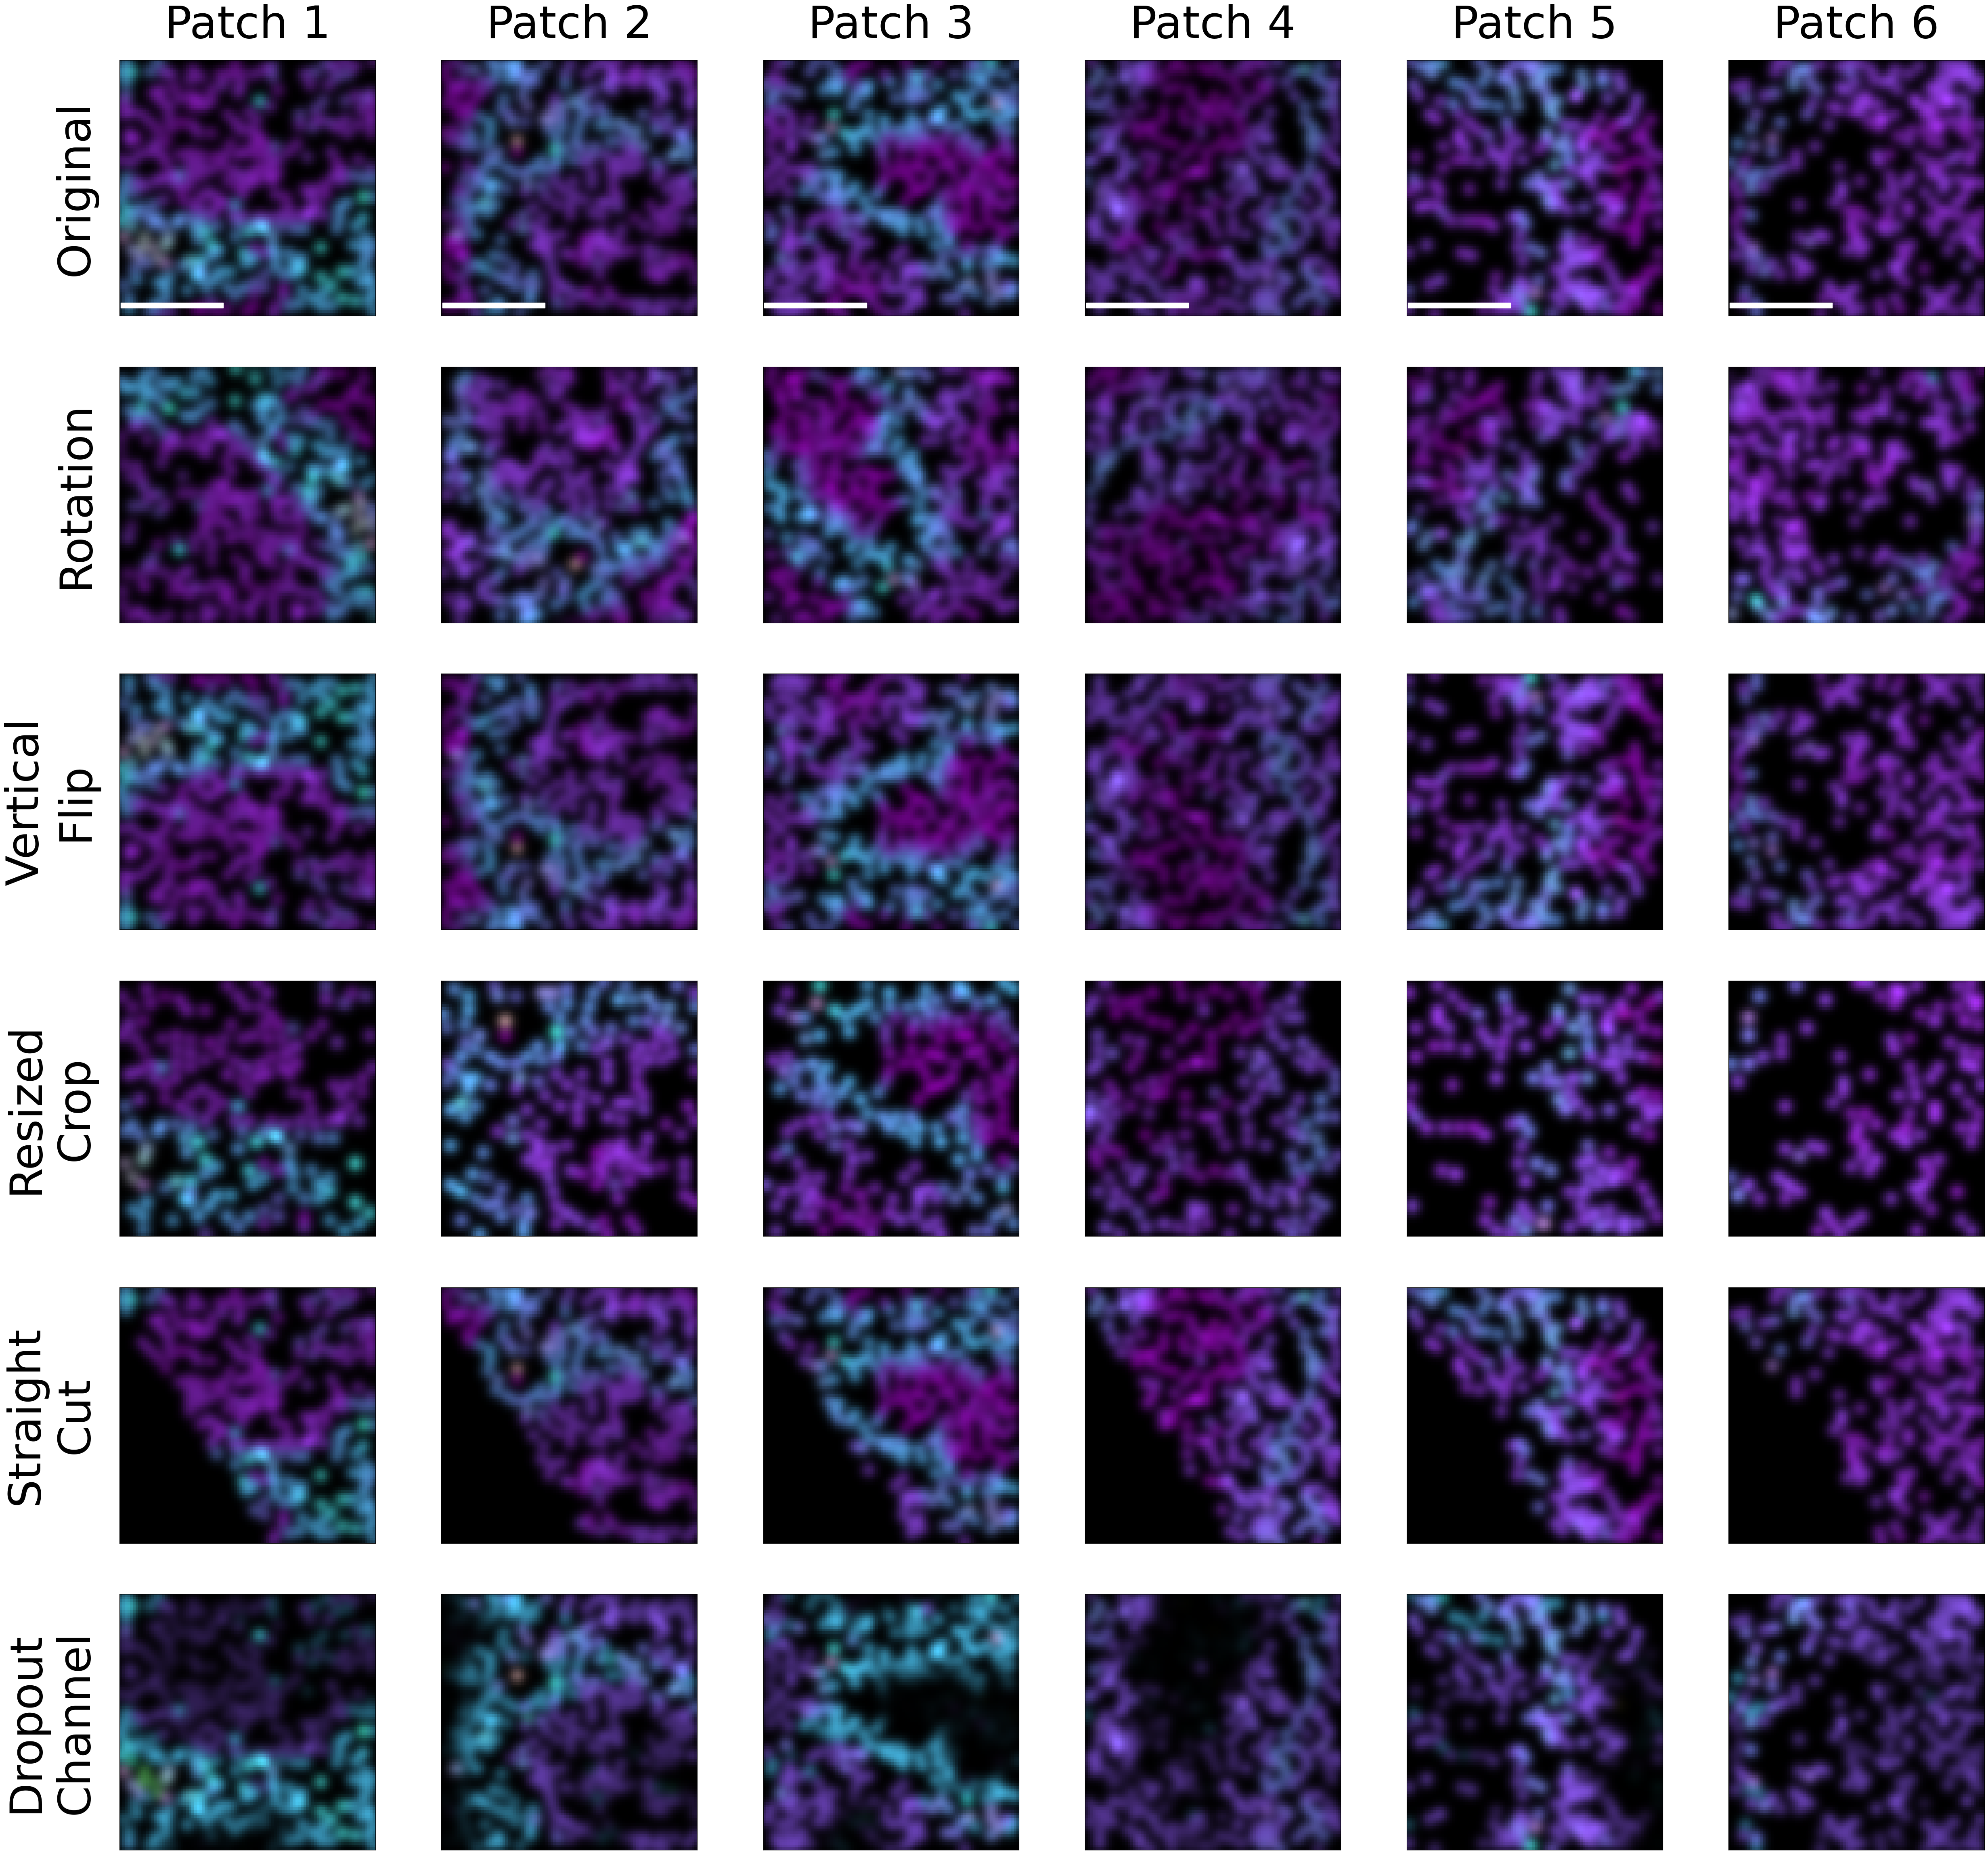

In [20]:
# Each column is a different patch
# Each row is a different instance of the random data-augmentation

titles = []
for r in range(n_augmentations):
    for c in range(n_examples):
        titles.append("crop = {}, augmentation = {}".format(c,r))

train_all_ch_fig = show_raw_all_channels(imgs_train, 
                                         cmap="viridis", 
                                         n_col=n_examples, 
                                         figsize=(10*n_examples, 8*imgs_train.shape[0]/5 * n_augmentations), 
                                        #  sup_title="Train crops, all channels",
                                        # show_axis=False,
                                        col_titles = ['Patch 1', 'Patch 2', 'Patch 3', 'Patch 4', 'Patch 5', 'Patch 6'],
                                        row_titles = ['Original', 'Rotation', 'Vertical\nFlip', 'Resized\nCrop', 'Straight\nCut', 'Dropout\nChannel'],
                                        show_ticks=False,
                                        fontsize=labelfontsize,
                                        labelpad=labelpad,
                                        scalebar_size=100)

# plt.subplots_adjust(wspace=-2.0)
train_all_ch_fig.savefig('./plots/supp_fig_1a.png', transparent=True, dpi=300)
train_all_ch_fig